# Parallelism

In this notebook we're going to go over how to run parallel sub-applications, using one of the examples from [the documentation](https://burr.dagworks.io/concepts/parallelism/).

We will be showing how to write a simple Burr application that compares models for the same prompt. We will go through the following, showing how Parallelism simplifies it:

1. Creating recursive sub-applications yourself
2. Wiring through tracking information with [recursive tracking capabilities](https://burr.dagworks.io/concepts/recursion/)
3. Using the map/reduce capabilities with Burr's [parallelism tooling](https://burr.dagworks.io/concepts/parallelism/)

# Imports

In [15]:
from burr.core import action, State, ApplicationBuilder, ApplicationContext
from burr.core.parallelism import MapStates, RunnableGraph
from typing import Callable, Generator, List, Dict, Any

from IPython.display import HTML, IFrame


import pprint

import openai


from concurrent.futures import ThreadPoolExecutor

In [16]:
%load_ext burr.integrations.notebook
%burr_ui

The burr.integrations.notebook extension is already loaded. To reload it, use:
  %reload_ext burr.integrations.notebook
Burr UI already running at http://127.0.0.1:7241


# Helper/Shared Functions

In this we'll set up the application -- creating our action functions as well as a few different helper functions we'll want to use.

The graph will have a simple (3-node) structure:

1. `process_input` -- pulls data in from the user at runtime
2. `run_llms` -- runs the different models in parallel
3. `join_outputs` -- writes a map of LLM -> result

We will first define nodes (1) and (3), then redefine (2) according to the approaches above.

In [17]:
MODELS = [
        "gpt-4",
        "gpt-4-turbo",
        "gpt-3.5-turbo",
        "gpt-3.5-turbo-16k",
        "text-davinci-003",
        "text-davinci-002",
]

def _query_llm(model: str, prompt: str) -> str:
    """Simple function to query our LLM -- we'll only support OpenAI for now."""
    
    if model not in MODELS:
        raise ValueError(f"Model '{model}' is not an OpenAI-supported model.")

    client = openai.Client()
    
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content


@action(reads=[], writes=["prompt", "models"])
def process_input(state: State, prompt: str, models: List[str]) -> State:
    """First node in our graph -- will take the prompt input and write to state"""
    return state.update(prompt=prompt, models=models)


@action(reads=["responses", "models"], writes=["all_responses"])
def join_outputs(state: State) -> State:
    """Final node, just joins in a dictionary"""
    joined_results = {}
    for response, model in zip(state["responses"], state["models"]):
        joined_results[model] = response
    return state.update(all_responses=joined_results)

# Approach (1) -- doing this manually

Nothing stops you from running multiple queries in the same action. In this we're going to just define the middle action to run in parallel -- it will launch an application in Burr, and wait for the results.

This is the "manual" approach -- how you might achieve parallelism without Burr. In it, we're going to do the following:

1. Create a sub-application with a single node that queries the LLM
2. Run multiple variants of it in parallel
3. Join the result

This is a useful approach as it is simple and looks like standard python code. That said, it lacks in visibility -- you have no way to know what the sub-LLM calls are doing.

First, we'll define the middle action. Next, we'll define the application. Then we can run!

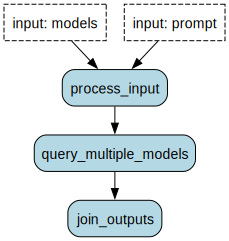

In [18]:
@action(reads=["models", "prompt"], writes=["responses"])
def query_multiple_models(state: State) -> State:
    """Query multiple models in parallel and store the results in the state."""
    models: List[str] = state["models"]
    prompt: str = state["prompt"]
    
    def query_model(model: str) -> str:
        return _query_llm(model, prompt)

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(query_model, model): model for model in models}
        results = {}
        for future in futures:
            model = futures[future]
            results[model] = future.result()
    
    return state.update(responses=results)

app = (
    ApplicationBuilder()
    .with_actions(
        process_input,
        query_multiple_models,
        join_outputs
    ).with_entrypoint("process_input")
    .with_tracker(project="demo_parallelism")
    .with_transitions(
        ("process_input", "query_multiple_models"),
        ("query_multiple_models", "join_outputs")
    )
    .build()
)
app

In [19]:
action_, _, state = app.run(
    inputs={"prompt": "what is the meaning of life?", "models" : ["gpt-4", "gpt-4-turbo", "gpt-3.5-turbo"]},
    halt_after=["join_outputs"]
)

In [20]:
IFrame(f'http://localhost:7241/project/demo_parallelism/null/{app.uid}', width="100%", height="700px")

# Approach (2) -- using recursion

Burr allows you to wire through tracking in the UI so you can visualize sub-applications. For this, we will be representing the LLM calls with different models as their own (single-node) application. While it is built for more complex sub-application shapes, it works quite well with the simplicity of a single node app.

In [ ]:
@action(reads=["model", "prompt"], writes=["response"])
def inner_query_model(state: State) -> State:
    return state.update(response=_query_llm(state["model"], state["prompt"]))
    
@action(reads=["models", "prompt"], writes=["responses"])
def query_multiple_models(state: State, __context: ApplicationContext) -> State:
    """Query multiple models in parallel and store the results in the state."""
    apps = []
    for model in state["models"]:
        apps.append(
            (
                model, 
                (
                    ApplicationBuilder()
                    .with_actions(query_model=inner_query_model)
                    .with_state(model=model, prompt=state["prompt"])
                    .with_tracker(project="demo_parallelism")
                    .with_spawning_parent(
                        app_id=__context.app_id,
                        sequence_id=__context.sequence_id
                    )
                    .with_entrypoint("query_model")
                )
            .build())
        )
        
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(app.run, halt_after=["query_model"]): model for model, app in apps}
        results = {}
        for future in futures:
            model = futures[future]
            results[model] = future.result()
    
    return state.update(responses=results)

app_recursion = (
    ApplicationBuilder()
    .with_actions(
        process_input,
        query_multiple_models,
        join_outputs
    ).with_entrypoint("process_input")
    .with_tracker(project="demo_parallelism")
    .with_transitions(
        ("process_input", "query_multiple_models"),
        ("query_multiple_models", "join_outputs")
    )
    .build()
)
app_recursion

In [ ]:
action_, _, state = app_recursion.run(
    inputs={"prompt": "what is the meaning of life?", "models" : ["gpt-4", "gpt-4-turbo", "gpt-3.5-turbo"]},
    halt_after=["join_outputs"]
)

In [ ]:
IFrame(f'http://localhost:7241/project/demo_parallelism/null/{app_recursion.uid}', width="100%", height="700px")

# Approach (3) -- using parallel constructs

We can use Burr's parallel construct to make this even easier. We will build a class that does mapping over states -- in this case, the class will create a recursive action for each model in the `models` field, 
enabling you to run the models in parallel. Burr's `MapStates` API will create the applications and run them in parallel. 

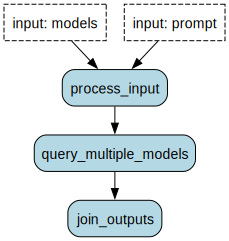

In [21]:
@action(reads=["model", "prompt"], writes=["response"])
def inner_query_model(state: State) -> State:
    return state.update(response=_query_llm(state["model"], state["prompt"]))
    
class RunOverMultiplePrompts(MapStates):
    def states(
        self, state: State, context: ApplicationContext, inputs: Dict[str, Any]
    ) -> Generator[State, None, None]:
        for model in state["models"]:
            yield state.update(model=model)

    def action(self, state: State, inputs: Dict[str, Any]) -> Callable:
        return inner_query_model

    def reduce(self, state: State, results: Generator[State, None, None]) -> State:
        state = state.update(results=[])
        responses = {model: output_state["response"] for model, output_state in zip(state["models"], results)}
        return state.update(responses=responses)
            
    @property
    def reads(self) -> List[str]:
        return ["models", "prompt"]

    @property
    def writes(self) -> List[str]:
        return ["responses"]

app_parallelism = (
    ApplicationBuilder()
    .with_actions(
        process_input,
        join_outputs,
        query_multiple_models=RunOverMultiplePrompts(),
    ).with_entrypoint("process_input")
    .with_tracker(project="demo_parallelism")
    .with_transitions(
        ("process_input", "query_multiple_models"),
        ("query_multiple_models", "join_outputs")
    )
    .build()
)
app_parallelism

In [22]:
action_, _, state = app_parallelism.run(
    inputs={"prompt": "what is the meaning of life?", "models" : ["gpt-4", "gpt-4-turbo", "gpt-3.5-turbo"]},
    halt_after=["join_outputs"]
)

In [23]:
IFrame(f'http://localhost:7241/project/demo_parallelism/null/{app_parallelism.uid}', width="100%", height="700px")